<a href="https://colab.research.google.com/github/AndresMontesDeOca/FundamentosML/blob/master/Energy%20EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

#### Demanda Eléctrica en Uruguay<br>

</center>

## Librerias

In [1]:
# Verificación e instalación
import importlib
import subprocess

def instalar_librerias(packages):
    [importlib.import_module(package) if package in locals() else subprocess.call(['pip', 'install', package]) for package in packages]

# Lista de librerías a verificar e instalar
listado_librerias = ['requests', 'json', 'datetime', 'gdown', 'numpy', 'pandas', 'seaborn', 'matplotlib', 'tabulate', 'scikit-learn', 'nltk', 'optuna', 'lightgbm', 'scipy']

# Verificar e instalar las librerías
instalar_librerias(listado_librerias)

In [2]:
# Importación
import requests
from io import BytesIO
from datetime import datetime
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna

# Ignorar Warnings
import warnings
warnings.filterwarnings("ignore")

## 1. Acceso a los datos



In [3]:
# URLs
urls = [
    "https://onedrive.live.com/download?resid=B5CCCD69939F6AA3%211005&authkey=!AHrqM5uDXJHb9f8&em=x&app=Excel",
    "https://onedrive.live.com/download?resid=B5CCCD69939F6AA3%211006&authkey=!APCDAiw_xs74xf8&em=x&app=Excel"
]

# Descarga de datos y carga en DataFrames
dataframes = [pd.read_excel(BytesIO(requests.get(url).content)) for url in urls]

# Nombres df
df_demanda_viento, df_temperatura = dataframes

# Previsualización
print("### DataFrame de demanda y viento:")
print(df_demanda_viento.head().to_markdown(index=False))
print("\n### DataFrame de temperatura:")
print(df_temperatura.head().to_markdown(index=False))


### DataFrame de demanda y viento:
| data_hora     |   Demanda_MW |   Vel_viento |
|:--------------|-------------:|-------------:|
| 2015-10-01 02 |     1032.75  |     29.9014  |
| 2015-10-01 03 |      960.612 |     17.3043  |
| 2015-10-01 04 |      938.912 |      8.70946 |
| 2015-10-01 05 |      943.277 |      7.25391 |
| 2015-10-01 06 |      977.781 |     16.47    |

### DataFrame de temperatura:
| Fecha               |   TempAire |
|:--------------------|-----------:|
| 2020-01-01 00:00:00 |       21   |
| 2020-01-01 01:00:00 |       21   |
| 2020-01-01 02:00:00 |       20.8 |
| 2020-01-01 03:00:00 |       20.6 |
| 2020-01-01 04:00:00 |       20.6 |




## 2. Exploración Inicial sobre Demanda y Velocidad



In [4]:
# No mostrar notación científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Información General
print(df_demanda_viento.info())

# Resumen descriptivo
print(df_demanda_viento.describe())

# Reestablecer notación científica
pd.reset_option('display.float_format')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   data_hora   65535 non-null  object 
 1   Demanda_MW  65535 non-null  float64
 2   Vel_viento  65535 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.5+ MB
None
                                 Demanda_MW  \
count                             65535.000   
mean       2968922103603471429081759744.000   
std      730611400952401882395598389248.000   
min                             -555555.000   
25%                                1091.628   
50%                                1265.121   
75%                                1432.302   
max   186877000000000019090986688839680.000   

                                  Vel_viento  
count                              65535.000  
mean       28572930498310260279209885696.000  
std      6903114358998181710542512586752.000  
min               

In [5]:
# Convertir la columna 'data_hora' a tipo datetime
df_demanda_viento['data_hora'] = pd.to_datetime(df_demanda_viento['data_hora'])
df_demanda_viento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data_hora   65535 non-null  datetime64[ns]
 1   Demanda_MW  65535 non-null  float64       
 2   Vel_viento  65535 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.5 MB


In [6]:
df_demanda_viento.head()

,data_hora,Demanda_MW,Vel_viento
0,2015-10-01 02:00:00,1032.749657,29.901389
1,2015-10-01 03:00:00,960.611900,17.304258
2,2015-10-01 04:00:00,938.911828,8.709460
3,2015-10-01 05:00:00,943.277163,7.253912
4,2015-10-01 06:00:00,977.780929,16.470050


In [7]:
# Resumen por percentiles (10% - 90%)
df_demanda_viento[['Demanda_MW', 'Vel_viento']].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

,Demanda_MW,Vel_viento
0.1,963.320548,6.269584
0.2,1049.948636,8.053771
0.3,1131.979247,9.922470
0.4,1207.205600,12.417292
0.5,1265.120510,15.552721
0.6,1323.459696,19.245680
0.7,1393.369256,23.803808
0.8,1475.123830,29.521596
0.9,1602.848296,38.107889


In [8]:
# Resumen por percentiles (91% - 99%)
df_demanda_viento[['Demanda_MW', 'Vel_viento']].quantile([0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

,Demanda_MW,Vel_viento
0.91,1618.805371,39.311099
0.92,1637.366449,40.637896
0.93,1657.382398,42.241740
0.94,1679.869551,44.151790
0.95,1703.961468,46.505453
0.96,1733.260065,49.389648
0.97,1767.140537,52.910388
0.98,1809.945472,57.389888
0.99,1880.579195,64.426435


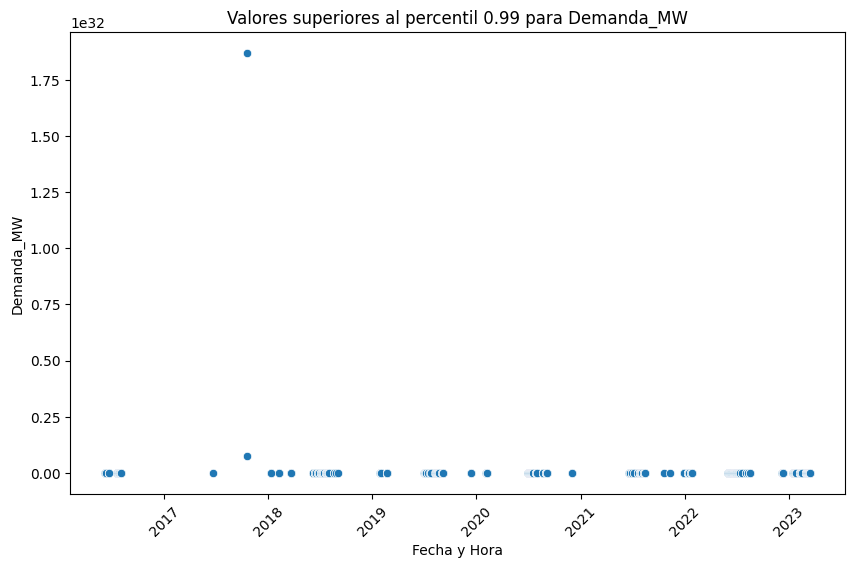

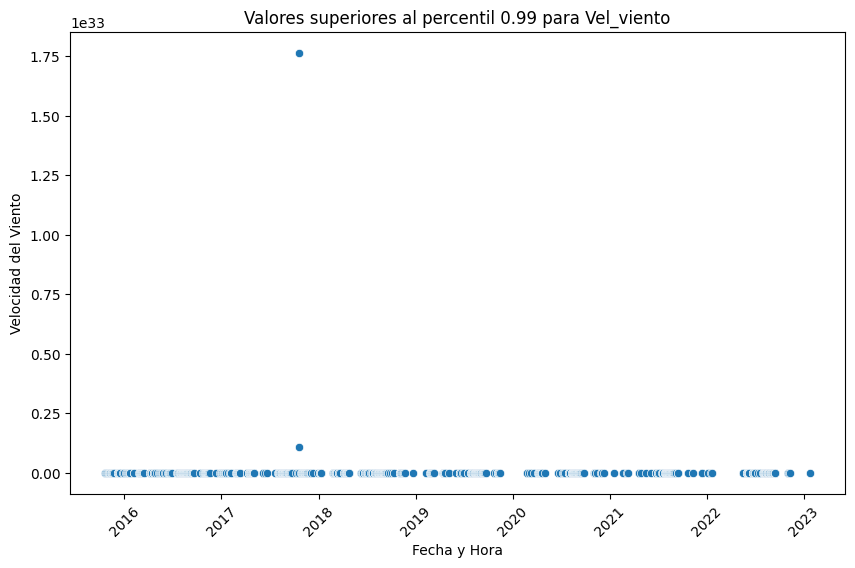

In [9]:
# Visualizar posibles outliers (superiores)
percentiles = df_demanda_viento[['Demanda_MW', 'Vel_viento']].quantile(0.99)

# Filtrar valores superiores al percentil 0.99
df_superiores_demanda = df_demanda_viento[df_demanda_viento['Demanda_MW'] > percentiles['Demanda_MW']]
df_superiores_velocidad = df_demanda_viento[df_demanda_viento['Vel_viento'] > percentiles['Vel_viento']]

# Graficar los valores superiores al percentil 0.99 para Demanda_MW
plt.figure(figsize=(10, 6))
sns.scatterplot(x='data_hora', y='Demanda_MW', data=df_superiores_demanda)
plt.title('Valores superiores al percentil 0.99 para Demanda_MW')
plt.xlabel('Fecha y Hora')
plt.ylabel('Demanda_MW')
plt.xticks(rotation=45)
plt.show()

# Graficar los valores superiores al percentil 0.99 para Vel_viento
plt.figure(figsize=(10, 6))
sns.scatterplot(x='data_hora', y='Vel_viento', data=df_superiores_velocidad)
plt.title('Valores superiores al percentil 0.99 para Vel_viento')
plt.xlabel('Fecha y Hora')
plt.ylabel('Velocidad del Viento')
plt.xticks(rotation=45)
plt.show()

In [10]:
# No mostrar notación científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Resumen por percentiles (91% - 99%)
print(df_superiores_demanda[['Demanda_MW']].quantile([0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]))

# Reestablecer notación científica
pd.reset_option('display.float_format')

       Demanda_MW
0.910    2044.228
0.920    2050.487
0.930    2061.866
0.940    2077.139
0.950    2088.430
0.960    2112.654
0.970    2125.103
0.980    2197.624
0.990    5937.088


In [11]:
# No mostrar notación científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Resumen por percentiles (91% - 99%)
print(df_superiores_demanda[['Vel_viento']].quantile([0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]))

# Reestablecer notación científica
pd.reset_option('display.float_format')

       Vel_viento
0.910      35.049
0.920      36.825
0.930      38.681
0.940      40.867
0.950      42.344
0.960      45.134
0.970      49.491
0.980      55.914
0.990   10384.087


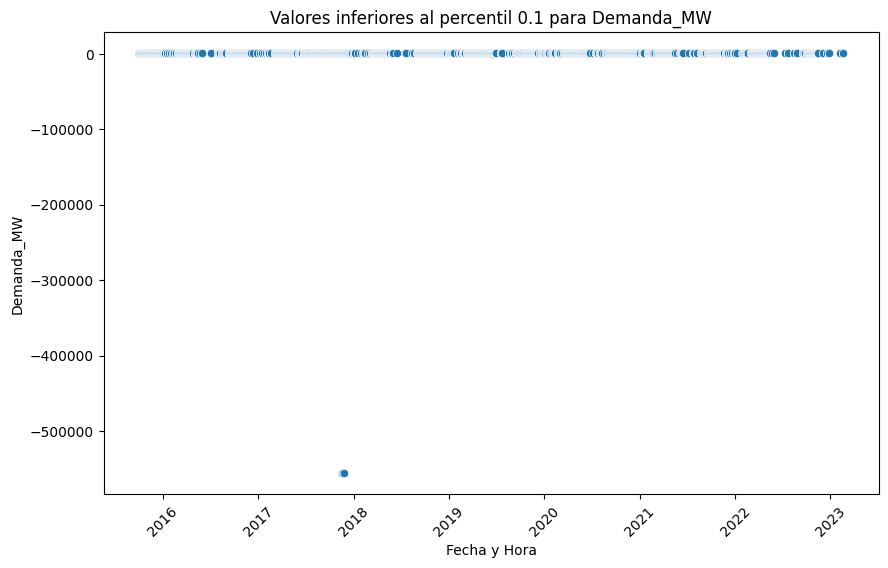

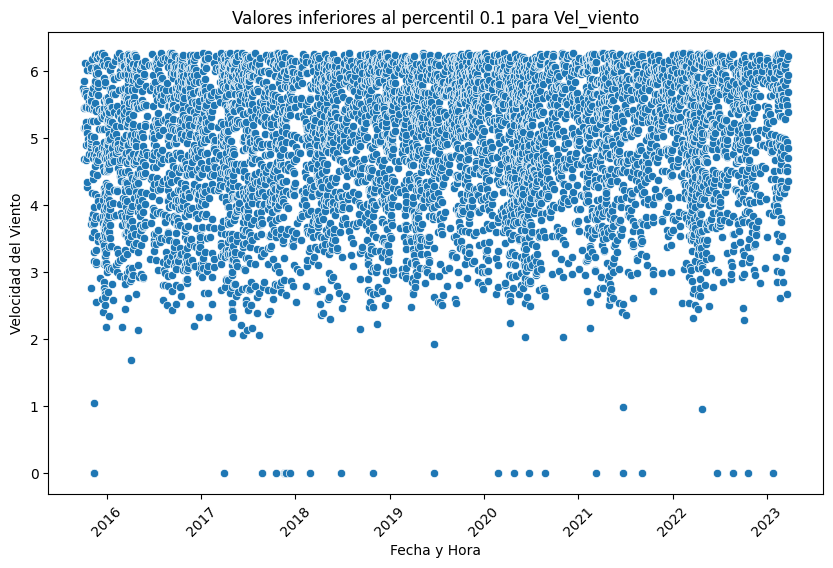

In [12]:
# Visualizar posibles outliers (inferiores)
percentiles = df_demanda_viento[['Demanda_MW', 'Vel_viento']].quantile(0.1)

# Filtrar valores superiores al percentil 0.99
df_inferiores_demanda = df_demanda_viento[df_demanda_viento['Demanda_MW'] < percentiles['Demanda_MW']]
df_inferiores_velocidad = df_demanda_viento[df_demanda_viento['Vel_viento'] < percentiles['Vel_viento']]

# Graficar los valores inferiores al percentil 0.1 para Demanda_MW
plt.figure(figsize=(10, 6))
sns.scatterplot(x='data_hora', y='Demanda_MW', data=df_inferiores_demanda)
plt.title('Valores inferiores al percentil 0.1 para Demanda_MW')
plt.xlabel('Fecha y Hora')
plt.ylabel('Demanda_MW')
plt.xticks(rotation=45)
plt.show()

# Graficar los valores inferiores al percentil 0.1 para Vel_viento
plt.figure(figsize=(10, 6))
sns.scatterplot(x='data_hora', y='Vel_viento', data=df_inferiores_velocidad)
plt.title('Valores inferiores al percentil 0.1 para Vel_viento')
plt.xlabel('Fecha y Hora')
plt.ylabel('Velocidad del Viento')
plt.xticks(rotation=45)
plt.show()

In [13]:
# No mostrar notación científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Resumen por percentiles (1% - 9%)
print(df_inferiores_demanda[['Demanda_MW']].quantile([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]))

# Reestablecer notación científica
pd.reset_option('display.float_format')

       Demanda_MW
0.010     763.662
0.020     783.256
0.030     795.324
0.040     802.203
0.050     808.328
0.060     814.778
0.070     819.197
0.080     823.824
0.090     829.124


In [14]:
# No mostrar notación científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Resumen por percentiles (1% - 9%)
print(df_inferiores_demanda[['Vel_viento']].quantile([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]))

# Reestablecer notación científica
pd.reset_option('display.float_format')

       Vel_viento
0.010       2.692
0.020       2.977
0.030       3.233
0.040       3.498
0.050       3.721
0.060       3.909
0.070       4.103
0.080       4.276
0.090       4.487


In [15]:
# Los datos sobre demanda y viento presentan valores atípicos;
# Para el caso de demanda se observa valores negativos y valores mayores a 2300 mWh
# Para el caso del viento se observa valores superiores a 100 km/h
# Estos valores se clasifican como erróneos por recomendación de quienes proveyeron los datos
# Por recomendacion de los proveedores del dato (Secrataria de energia del Uruguay) se imputa los valores negativos de demanda por 83 (valor minimo usual) y por 2300 los superiores a 2300
# En el caso del viento se establece como valor maximo 100 (mayor a 100 implica tornado, evento muy atipico en uruguay)

In [16]:
# Reemplazar valores negativos en Demanda_MW por 83 y valores mayores a 2300 por 2300
# df_demanda_viento['Demanda_MW'] = df_demanda_viento['Demanda_MW'].apply(lambda x: 83 if x < 0 else (2300 if x > 2300 else x))

# MODIFICACION ANDY ->
df_demanda_viento['Demanda_MW'] = df_demanda_viento['Demanda_MW'].apply(lambda x: None if x < 600 else (None if x > 2300 else x))
df_demanda_viento['Demanda_MW'].fillna(method='backfill', inplace=True)

# Reemplazar valores mayores a 100 en Vel_viento por 100
df_demanda_viento['Vel_viento'] = df_demanda_viento['Vel_viento'].apply(lambda x: 100 if x > 100 else x)

### 2.1 Exploración Inicial sobre Temperatura



In [17]:
# No mostrar notación científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Información General
print(df_temperatura.info())

# Resumen descriptivo
print(df_temperatura['TempAire'].describe())

# Reestablecer notación científica
pd.reset_option('display.float_format')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26277 entries, 0 to 26276
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Fecha     26277 non-null  datetime64[ns]
 1   TempAire  26277 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 410.7 KB
None
count   26277.000
mean       16.559
std         5.922
min         0.000
25%        12.200
50%        16.600
75%        20.800
max        38.800
Name: TempAire, dtype: float64


In [18]:
df_temperatura.head()

,Fecha,TempAire
0,2020-01-01 00:00:00,21.0
1,2020-01-01 01:00:00,21.0
2,2020-01-01 02:00:00,20.8
3,2020-01-01 03:00:00,20.6
4,2020-01-01 04:00:00,20.6


In [19]:
# Resumen por percentiles (10% - 90%)
df_temperatura['TempAire'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

0.1     8.8
0.2    11.2
0.3    13.1
0.4    14.8
0.5    16.6
0.6    18.4
0.7    20.0
0.8    21.8
0.9    24.1
Name: TempAire, dtype: float64

## 3. Unificacion



In [20]:
# Union de los DataFrames usando merge y outer join
df = pd.merge(df_demanda_viento, df_temperatura, left_on='data_hora', right_on='Fecha', how='outer')

# Ordenar por la columna de fecha/hora
df = df.sort_values(by='data_hora')

# Rellenar los valores nulos con NaN
df = df.fillna(value=pd.NA)

# Previsualizacion
df.head()

,data_hora,Demanda_MW,Vel_viento,Fecha,TempAire
0,2015-10-01 02:00:00,1032.749657,29.901389,NaT,NaN
1,2015-10-01 03:00:00,960.611900,17.304258,NaT,NaN
2,2015-10-01 04:00:00,938.911828,8.709460,NaT,NaN
3,2015-10-01 05:00:00,943.277163,7.253912,NaT,NaN
4,2015-10-01 06:00:00,977.780929,16.470050,NaT,NaN


In [21]:
# Limites de fecha del DataFrame df_demanda_viento
fecha_min_demanda = df_demanda_viento['data_hora'].min()
fecha_max_demanda = df_demanda_viento['data_hora'].max()
print(f"Fecha mínima en df_demanda_viento: {fecha_min_demanda}")
print(f"Fecha máxima en df_demanda_viento: {fecha_max_demanda}")

# Limites de fecha del DataFrame df_temperatura
fecha_min_temperatura = df_temperatura['Fecha'].min()
fecha_max_temperatura = df_temperatura['Fecha'].max()
print(f"Fecha mínima en df_temperatura: {fecha_min_temperatura}")
print(f"Fecha máxima en df_temperatura: {fecha_max_temperatura}")


Fecha mínima en df_demanda_viento: 2015-10-01 02:00:00
Fecha máxima en df_demanda_viento: 2023-03-23 16:00:00
Fecha mínima en df_temperatura: 2020-01-01 00:00:00
Fecha máxima en df_temperatura: 2022-12-31 23:00:00


In [ ]:
# Filtrar las fecha del dataframe unificado
df = df[(df['data_hora'] >= fecha_min_temperatura) & (df['data_hora'] <= fecha_max_temperatura)]
df = df.drop(columns=['Fecha'])

# Previsualizacion
df.head()

,data_hora,Demanda_MW,Vel_viento,TempAire
37270,2020-01-01 00:00:00,1159.488814,20.097612,21.0
37271,2020-01-01 01:00:00,1081.818798,7.237234,21.0
37272,2020-01-01 02:00:00,1072.515889,10.902265,20.8
37273,2020-01-01 03:00:00,1029.419464,15.577264,20.6
37274,2020-01-01 04:00:00,979.258112,13.301302,20.6


In [22]:
# Verificar si el dataframe esta completo (que no se omita alguna hora o dia)
fechas_esperadas = pd.date_range(start=fecha_min_temperatura, end=fecha_max_temperatura, freq='H')
todas_las_fechas_presentes = set(fechas_esperadas) == set(df['data_hora'])

if todas_las_fechas_presentes:
    print("El DataFrame tiene todas las fechas completas.")
else:
    print("El DataFrame tiene fechas faltantes.")

El DataFrame tiene fechas faltantes.


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data_hora   65535 non-null  datetime64[ns]
 1   Demanda_MW  65535 non-null  float64       
 2   Vel_viento  65535 non-null  float64       
 3   Fecha       26277 non-null  datetime64[ns]
 4   TempAire    26277 non-null  float64       
dtypes: datetime64[ns](2), float64(3)
memory usage: 2.5 MB


In [24]:
# Imputar los valores faltantes del temperatura utilizando interpolacion lineal

# Ordenar el DataFrame
df = df.sort_values(by='data_hora')

# Imputar los valores faltantes
df['TempAire'] = df['TempAire'].interpolate()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data_hora   65535 non-null  datetime64[ns]
 1   Demanda_MW  65535 non-null  float64       
 2   Vel_viento  65535 non-null  float64       
 3   Fecha       26277 non-null  datetime64[ns]
 4   TempAire    28265 non-null  float64       
dtypes: datetime64[ns](2), float64(3)
memory usage: 2.5 MB


In [25]:
# Renombrar las columnas
df = df.rename(columns={
    'data_hora': 'fecha_hora',
    'Demanda_MW': 'demanda',
    'Vel_viento': 'viento',
    'TempAire': 'temperatura'
})
df.head()

,fecha_hora,demanda,viento,Fecha,temperatura
0,2015-10-01 02:00:00,1032.749657,29.901389,NaT,NaN
1,2015-10-01 03:00:00,960.611900,17.304258,NaT,NaN
2,2015-10-01 04:00:00,938.911828,8.709460,NaT,NaN
3,2015-10-01 05:00:00,943.277163,7.253912,NaT,NaN
4,2015-10-01 06:00:00,977.780929,16.470050,NaT,NaN


In [26]:
# Configurar 'fecha_hora' como índice
df.set_index('fecha_hora', inplace=True)
df.head()

,demanda,viento,Fecha,temperatura
fecha_hora,,,,
2015-10-01 02:00:00,1032.749657,29.901389,NaT,NaN
2015-10-01 03:00:00,960.611900,17.304258,NaT,NaN
2015-10-01 04:00:00,938.911828,8.709460,NaT,NaN
2015-10-01 05:00:00,943.277163,7.253912,NaT,NaN
2015-10-01 06:00:00,977.780929,16.470050,NaT,NaN


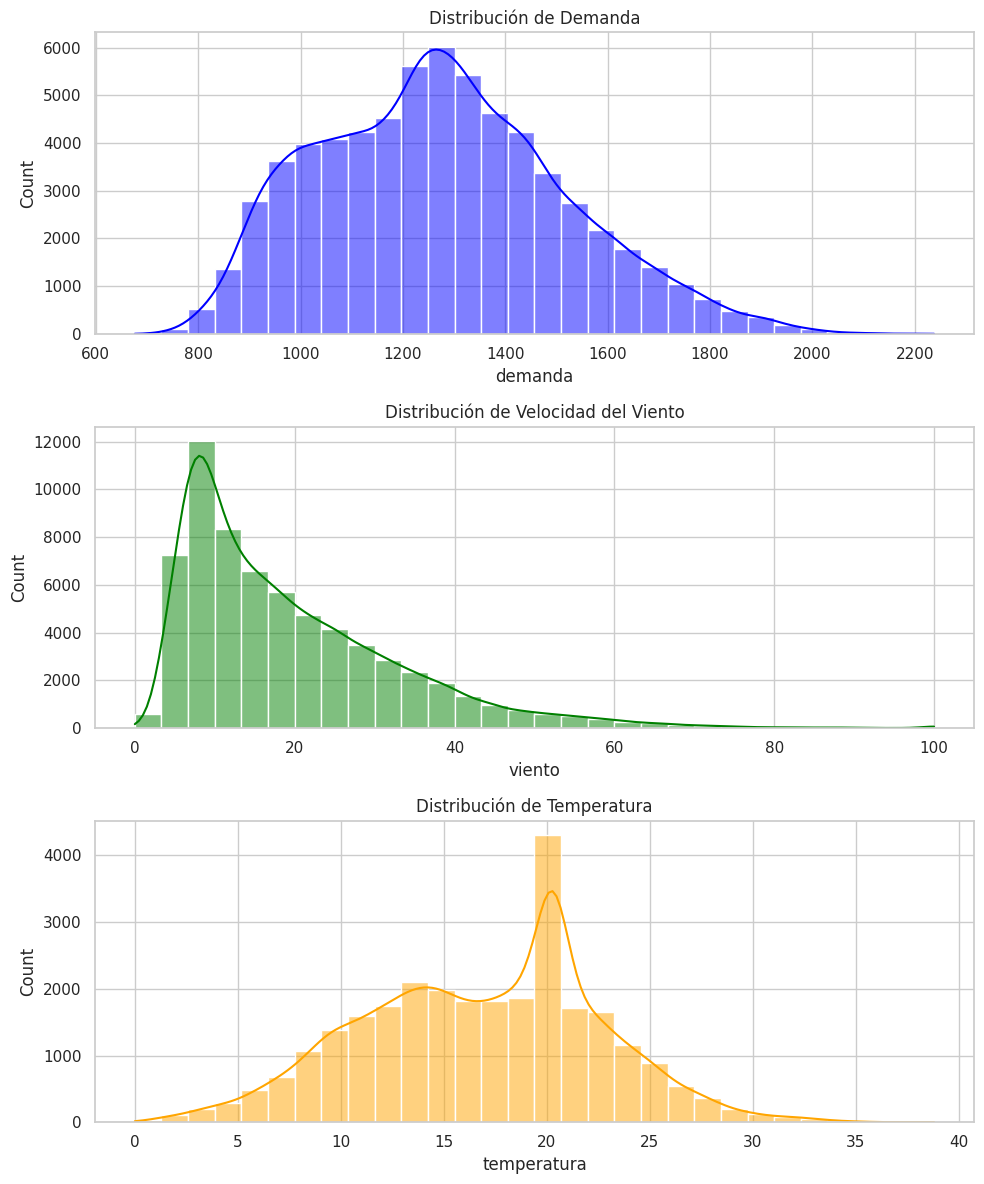

In [27]:
# Distribucion de las variables de interes
sns.set(style="whitegrid")

# Crear subplots para la distribución de demanda, viento y temperatura
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

# Gráfico de distribución de la demanda
sns.histplot(df['demanda'], bins=30, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Distribución de Demanda')

# Gráfico de distribución de la velocidad del viento
sns.histplot(df['viento'], bins=30, kde=True, color='green', ax=axes[1])
axes[1].set_title('Distribución de Velocidad del Viento')

# Gráfico de distribución de la temperatura
sns.histplot(df['temperatura'], bins=30, kde=True, color='orange', ax=axes[2])
axes[2].set_title('Distribución de Temperatura')

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

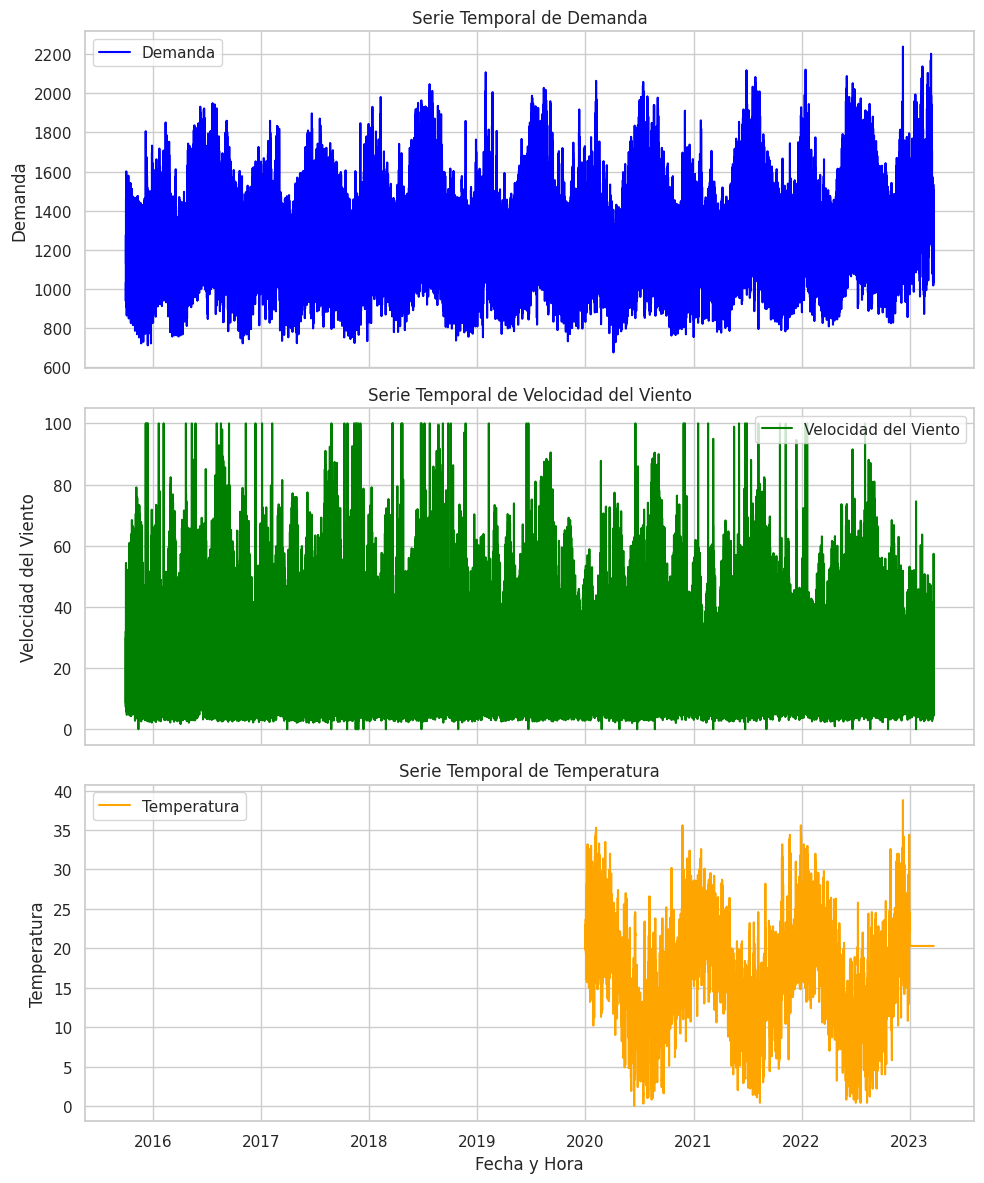

In [28]:
# Distribucion de las variables de interes a lo largo del tiempo
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Crear subgráficos para cada serie temporal
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True)

# Gráfico de línea para la serie temporal de Demanda
sns.lineplot(x=df.index, y=df['demanda'], ax=axes[0], label='Demanda', color='blue')

# Configuraciones del gráfico de demanda
axes[0].set_title('Serie Temporal de Demanda')
axes[0].set_ylabel('Demanda')
axes[0].grid(True)
axes[0].legend()

# Gráfico de línea para la serie temporal de Velocidad del Viento
sns.lineplot(x=df.index, y=df['viento'], ax=axes[1], label='Velocidad del Viento', color='green')

# Configuraciones del gráfico de velocidad del viento
axes[1].set_title('Serie Temporal de Velocidad del Viento')
axes[1].set_ylabel('Velocidad del Viento')
axes[1].grid(True)
axes[1].legend()

# Gráfico de línea para la serie temporal de Temperatura
sns.lineplot(x=df.index, y=df['temperatura'], ax=axes[2], label='Temperatura', color='orange')

# Configuraciones del gráfico de temperatura
axes[2].set_title('Serie Temporal de Temperatura')
axes[2].set_xlabel('Fecha y Hora')
axes[2].set_ylabel('Temperatura')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()

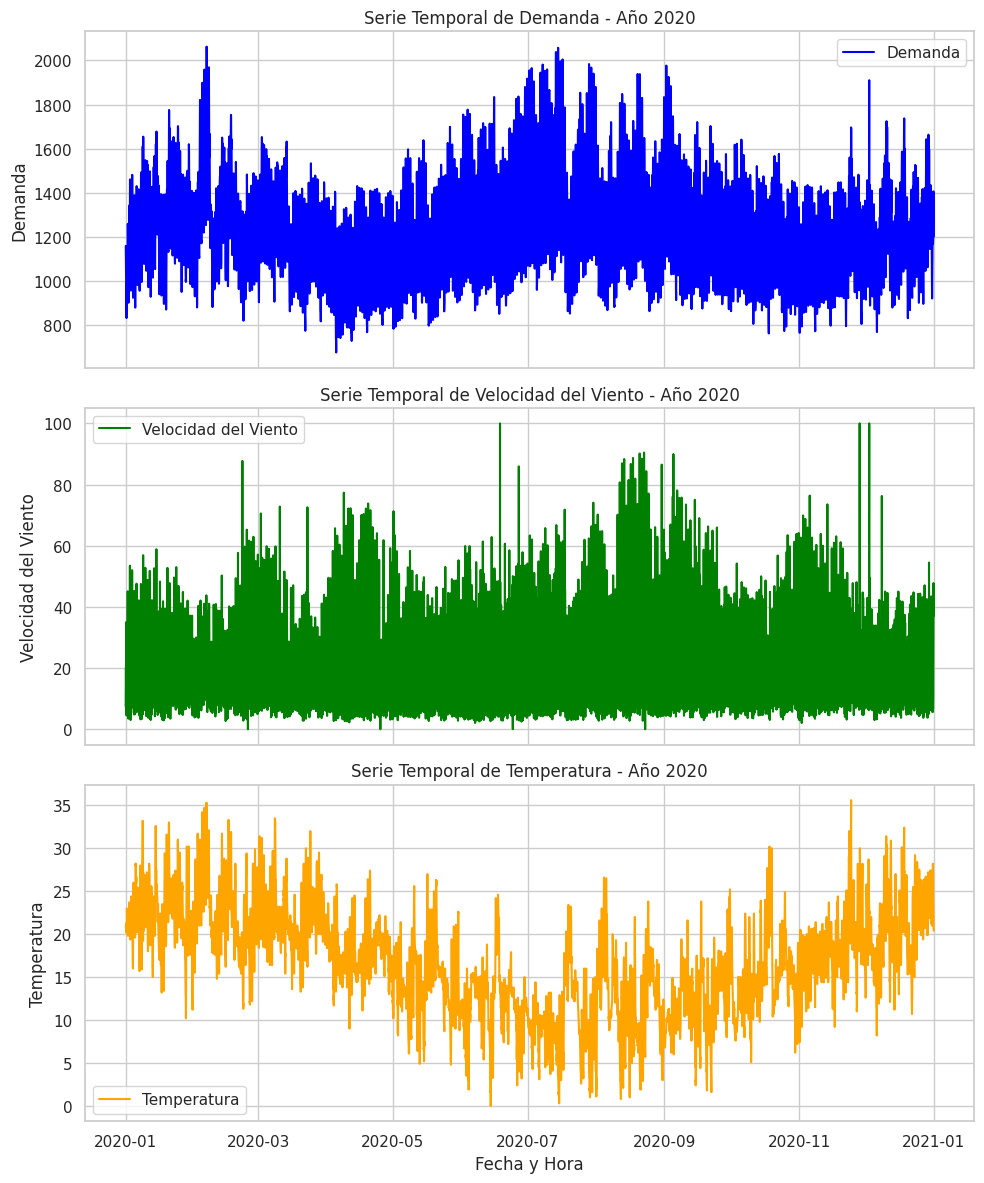

In [29]:
# Distribucion de las variables de interes en 2020

# Filtrar el DataFrame para incluir solo el año 2020
df_2020 = df['2020-01-01':'2020-12-31']

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear subgráficos para cada serie temporal
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True)

# Gráfico de línea para la serie temporal de Demanda en 2020
sns.lineplot(x=df_2020.index, y=df_2020['demanda'], ax=axes[0], label='Demanda', color='blue')

# Configuraciones del gráfico de demanda
axes[0].set_title('Serie Temporal de Demanda - Año 2020')
axes[0].set_ylabel('Demanda')
axes[0].grid(True)
axes[0].legend()

# Gráfico de línea para la serie temporal de Velocidad del Viento en 2020
sns.lineplot(x=df_2020.index, y=df_2020['viento'], ax=axes[1], label='Velocidad del Viento', color='green')

# Configuraciones del gráfico de velocidad del viento
axes[1].set_title('Serie Temporal de Velocidad del Viento - Año 2020')
axes[1].set_ylabel('Velocidad del Viento')
axes[1].grid(True)
axes[1].legend()

# Gráfico de línea para la serie temporal de Temperatura en 2020
sns.lineplot(x=df_2020.index, y=df_2020['temperatura'], ax=axes[2], label='Temperatura', color='orange')

# Configuraciones del gráfico de temperatura
axes[2].set_title('Serie Temporal de Temperatura - Año 2020')
axes[2].set_xlabel('Fecha y Hora')
axes[2].set_ylabel('Temperatura')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()

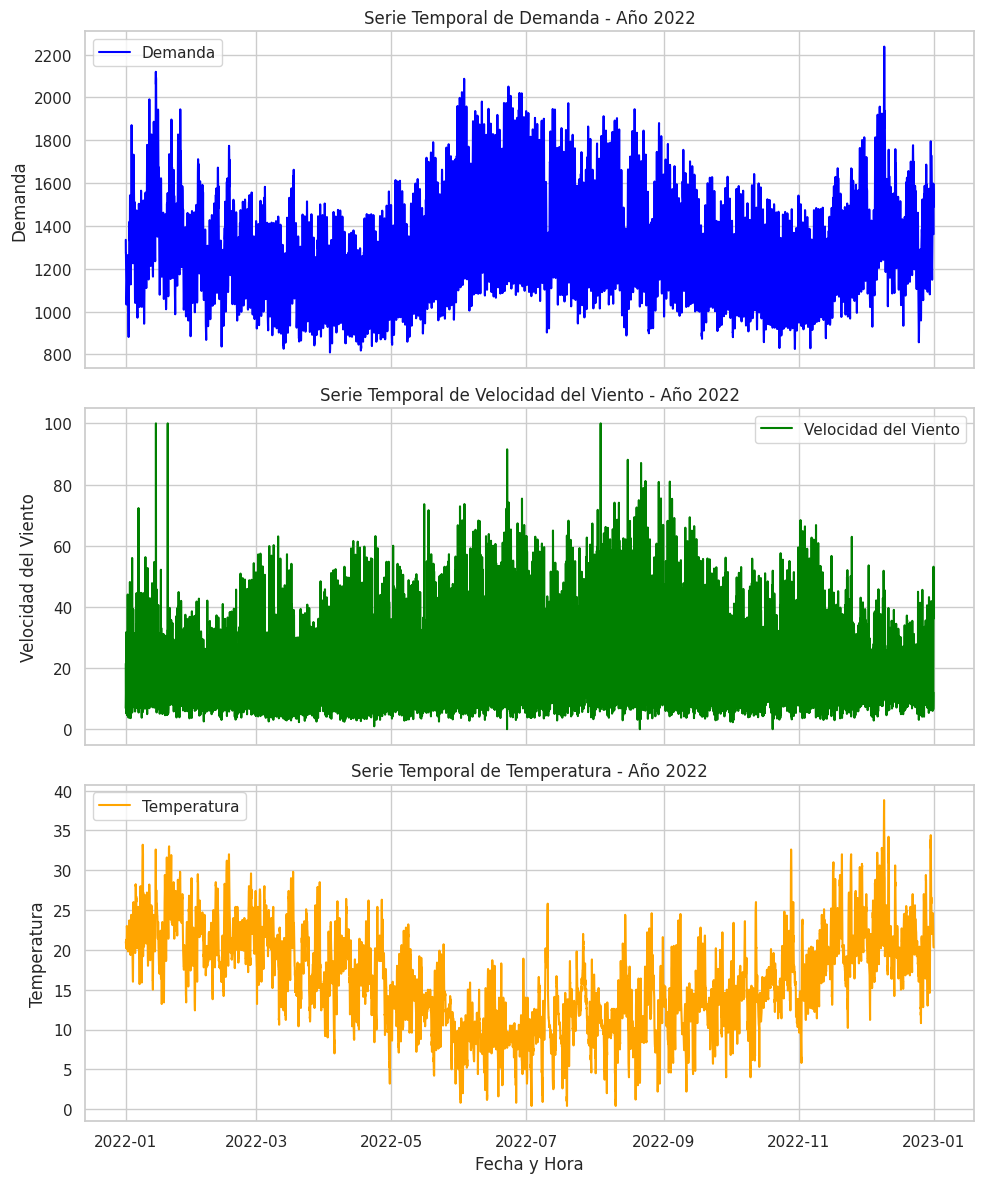

In [30]:
# Distribucion de las variables de interes en 2022

# Filtrar el DataFrame para incluir solo el año 2022
df_2022 = df['2022-01-01':'2022-12-31']

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear subgráficos para cada serie temporal
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True)

# Gráfico de línea para la serie temporal de Demanda en 2022
sns.lineplot(x=df_2022.index, y=df_2022['demanda'], ax=axes[0], label='Demanda', color='blue')

# Configuraciones del gráfico de demanda
axes[0].set_title('Serie Temporal de Demanda - Año 2022')
axes[0].set_ylabel('Demanda')
axes[0].grid(True)
axes[0].legend()

# Gráfico de línea para la serie temporal de Velocidad del Viento en 2022
sns.lineplot(x=df_2022.index, y=df_2022['viento'], ax=axes[1], label='Velocidad del Viento', color='green')

# Configuraciones del gráfico de velocidad del viento
axes[1].set_title('Serie Temporal de Velocidad del Viento - Año 2022')
axes[1].set_ylabel('Velocidad del Viento')
axes[1].grid(True)
axes[1].legend()

# Gráfico de línea para la serie temporal de Temperatura en 2022
sns.lineplot(x=df_2022.index, y=df_2022['temperatura'], ax=axes[2], label='Temperatura', color='orange')

# Configuraciones del gráfico de temperatura
axes[2].set_title('Serie Temporal de Temperatura - Año 2022')
axes[2].set_xlabel('Fecha y Hora')
axes[2].set_ylabel('Temperatura')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()